In [2]:
from functools import partial

import pandas as pd
import numpy as np
from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_ribbon,
    theme_bw,
    theme,
    theme_matplotlib,
    facet_wrap,
    geom_hline,
)
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [13]:
df = pd.read_csv("prepared_data.csv", index_col="SEQN").rename(
    {"any_caffeine.1": "any_caffeine_log"}, axis=1
)
df.head()

#df["any_vig_activity"] = df["activity_vig_min"] >= 10

,knn_impute__bmi_total,knn_impute__demo_age,knn_impute__activity_sed_min,simple_impute__alcohol_nmbr_drinks,simple_impute__poverty_num,zero_impute__activity_vig_min,zero_impute__activity_mod_min,zero_impute__smoking_cigs_pd,static_impute__occ_hours_worked,passthrough__any_caffeine,passthrough__is_male,passthrough__any_caffeine_log,one_hot__demo_race_str_asian_non_hisp,one_hot__demo_race_str_black,one_hot__demo_race_str_hispanic_other,one_hot__demo_race_str_mexican_american,one_hot__demo_race_str_other_or_multi,kidney_had_stones,kidney_passed_stone,kidney_weak_failing
SEQN,,,,,,,,,,,,,,,,,,,,
109266,37.80,29.0,480.0,1.0,5.00,60.0,30.0,0.0,40.000000,25.0,False,3.258097,1.0,0.0,0.0,0.0,0.0,False,False,False
109267,22.68,21.0,540.0,2.0,5.00,90.0,0.0,0.0,40.000000,0.0,False,0.000000,0.0,0.0,1.0,0.0,0.0,False,False,False
109268,21.94,18.0,540.0,2.0,1.19,0.0,0.0,0.0,39.528287,0.0,False,0.000000,0.0,0.0,0.0,0.0,0.0,False,False,False
109271,29.70,49.0,60.0,2.0,1.20,0.0,0.0,20.0,39.528287,2087.5,True,7.644201,0.0,0.0,0.0,0.0,0.0,False,False,False
109273,21.90,36.0,180.0,2.0,0.53,0.0,120.0,15.0,28.000000,21.5,True,3.113515,0.0,0.0,0.0,0.0,0.0,False,False,False


{'fit_time': array([17.10789752, 15.40959573, 14.61350465, 15.70280933, 15.10076046]), 'score_time': array([0.92803121, 0.92735553, 0.91955924, 0.91914964, 0.92286611]), 'test_accuracy': array([0.91077875, 0.90974729, 0.91026302, 0.91073271, 0.91073271]), 'train_accuracy': array([1., 1., 1., 1., 1.]), 'test_roc_auc': array([0.62181934, 0.60632925, 0.6247794 , 0.6276294 , 0.6622247 ]), 'train_roc_auc': array([1., 1., 1., 1., 1.])}
cv accuracy: 0.9104508989611425
cv auc score: 0.6285564162912554


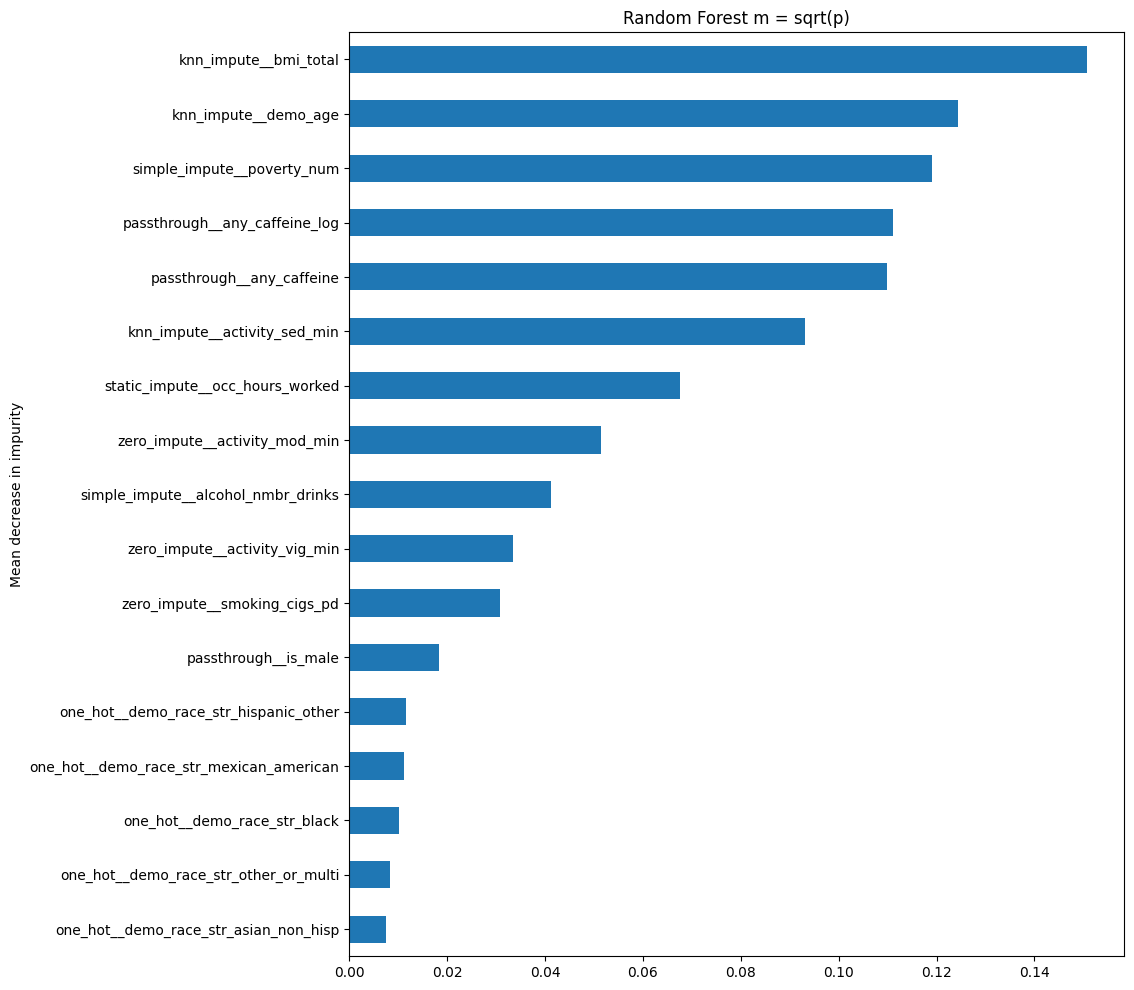

In [28]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rfc = RandomForestClassifier(n_estimators=1000, max_features = "sqrt", random_state=0, oob_score=True)
#print(df)
train_data_X = df.loc[:,[
        "knn_impute__bmi_total",
        "knn_impute__demo_age",
        "knn_impute__activity_sed_min",
        "simple_impute__alcohol_nmbr_drinks",
        "simple_impute__poverty_num",
        "zero_impute__activity_vig_min",
        "zero_impute__activity_mod_min",
        "zero_impute__smoking_cigs_pd",
        "static_impute__occ_hours_worked",
        "passthrough__any_caffeine",
        "passthrough__is_male",
        "passthrough__any_caffeine_log",
        "one_hot__demo_race_str_asian_non_hisp",
        "one_hot__demo_race_str_black",
        "one_hot__demo_race_str_hispanic_other",
        "one_hot__demo_race_str_mexican_american",
        "one_hot__demo_race_str_other_or_multi",
        "kidney_had_stones",
        #"kidney_passed_stone",
        #"kidney_weak_failing"
    ]
]
train_data_Y = train_data_X.pop("kidney_had_stones")

#print(train_data_X.isna())
cv_data = cross_validate(rfc, train_data_X, train_data_Y, cv=5, scoring=['accuracy', 'roc_auc'], return_train_score=True)
print(cv_data)
print("cv accuracy: " + str(np.mean(cv_data["test_accuracy"])))
print("cv auc score: " + str(np.mean(cv_data["test_roc_auc"])))

rfc.fit(train_data_X, train_data_Y)

importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index= rfc.feature_names_in_)

plt.figure(figsize=(10,12))
forest_importances.sort_values(ascending = True).plot.barh()
plt.title("Random Forest m = sqrt(p)")
plt.ylabel("Mean decrease in impurity")
plt.show()